# Análise dos resultados (V2)

## Importação de módulos

In [7]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as w
import colorcet as cc
import seaborn as sns

O módulo `utils.py` contém definições a respeito das configurações dos experimentos:

In [186]:
%load_ext autoreload
%autoreload 2
import utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Coletando resultados

Primeiramente, é necessário coletar os resultados obtidos com os experimentos.
Atualmente, eles estão quase terminados, faltando apenas algumas execuções do SVM+EER para alguns datasets.

In [4]:
def get_results_info(file_list: list) -> pd.DataFrame:
    
    results_info = pd.DataFrame(file_list, columns=["file"])
    results_info[["dataset", "split", "learner", "method"]] = results_info.file.str.split("_", n=3, expand=True)
    results_info['file'] = results_info.file.map(lambda x: os.path.join(RESULTS_V2_PATH, x))
    results_info['method'] = results_info.method.apply(lambda x: x.split('.')[0])
    
    return results_info

In [13]:
def get_results_df(results_info) -> pd.DataFrame:
    df = pd.concat(pd.read_csv(f) for f in  results_info.file)
    
    return df
    

Os resultados estão localizados no diretório `RESULTS_V2_PATH`, importado no módulo `utils.py`

In [5]:
csv_files = !ls  $utils.RESULTS_V2_PATH

Agora podemos pegar as informações a respeito de cada uma das configurações:

In [6]:
results_info = get_results_info(csv_files)
results_info.head()

,file,dataset,split,learner,method
0,../results/v2/abalone-3class_1x5_5NN_borderlin...,abalone-3class,1x5,5NN,borderline_points_sampling
1,../results/v2/abalone-3class_1x5_5NN_class_bal...,abalone-3class,1x5,5NN,class_balance_sampling
2,../results/v2/abalone-3class_1x5_5NN_class_lik...,abalone-3class,1x5,5NN,class_likelihood_sampling
3,../results/v2/abalone-3class_1x5_5NN_class_lik...,abalone-3class,1x5,5NN,class_likeliood_diff_sampling
4,../results/v2/abalone-3class_1x5_5NN_density_w...,abalone-3class,1x5,5NN,density_weighted_sampling


Agora podemos agregar todos os resultados em um único `DataFrame`

In [17]:
%%time
results_df = get_results_df(results_info)

CPU times: user 10.2 s, sys: 261 ms, total: 10.5 s
Wall time: 10.5 s


In [18]:
results_df.head()

,time,dataset,classifier,method,run,fold,query,kappa
0,2025-03-23 18:41:24.629248,abalone-3class,5NN,borderline_points_sampling,0,0,0,0.000000
1,2025-03-23 18:41:29.325717,abalone-3class,5NN,borderline_points_sampling,0,0,1,0.231167
2,2025-03-23 18:41:34.087002,abalone-3class,5NN,borderline_points_sampling,0,0,2,0.314495
3,2025-03-23 18:41:38.828586,abalone-3class,5NN,borderline_points_sampling,0,0,3,0.249614
4,2025-03-23 18:41:43.579852,abalone-3class,5NN,borderline_points_sampling,0,0,4,0.212956


## Análise de curvas de aprendizado

Aqui vamos analisar comos os métodos de aprendizado ativo se comportaram para cada par `(learner, dataset)`

In [8]:
# Definindo as cores para os plots:
n_methods = results_info.method.nunique()
color_list = sns.color_palette(cc.glasbey_dark ,n_colors=n_methods)
COLOR_DICT = dict(zip(results_info.method.unique().tolist(), color_list))
COLOR_DICT["random_sampling"] = "firebrick"

In [10]:
def plot_learning_curve(dataset, learner):

    plt.close()
    fig, ax = plt.subplots()
    ax.grid(True)
    ax.set_ylim(-1,1)
    ax.set_title(f"Average learning curves for AL methods")
    
    
    result_files = results_info[(results_info.learner == learner) & (results_info.dataset == dataset)].file.tolist()

    results_df = pd.concat(pd.read_csv(f) for f in result_files)

    auc_dict = {}
    for method, data in results_df.groupby("method"):
        avg_scores =  data.groupby("query").kappa.mean()
        auc = (np.trapz(avg_scores, avg_scores.index))
        auc_dict[method] = auc

    ranked_method_list = sorted(auc_dict.items(), key=lambda x: x[1],reverse=True)

    i=0
    for method, _ in ranked_method_list:
        avg_curve = results_df[results_df.method == method].groupby("query").kappa.mean()
        ax.plot(avg_curve.rolling(window=5, min_periods=1).mean(),
                utils.get_style(method), linewidth=0.5, color=COLOR_DICT[method], label=ABREV_DICT[method],
            markevery=(0.3, 0.2))
        i+=1
        
    ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.02), ncols=1, prop={'size':8}, framealpha=1)

In [12]:
w.interact(plot_learning_curve,
          dataset=w.SelectionSlider(options=utils.DATASET_LIST),
          learner=w.ToggleButtons(options=utils.ABREV_MODEL.keys(), value="SVC"))

interactive(children=(SelectionSlider(description='dataset', options=('abalone-3class', 'artificial-characters…

<function __main__.plot_learning_curve(dataset, learner)>

## Curvas de Ranking

Primeiro, é necessário calcular o rank de cada query:

In [33]:
def get_avg_ranks(results_df) -> pd.DataFrame:
    # Afere o kappa médio para cada query registrada
    avg_kappa = results_df.groupby(["classifier","method", "query", "dataset"]).kappa.mean()

    # Afere o rank de cada método para cada dataset
    ranks_df = avg_kappa.to_frame(name="kappa")
    ranks_df['rank'] = ranks_df.groupby(["query", "dataset"]).kappa.rank(ascending=False)

    # Calcula rank médio por query para cada 
    avg_ranks = ranks_df.groupby(["classifier", "method", "query"])["rank"].mean()
    return avg_ranks


In [34]:
avg_ranks_df = get_avg_ranks(results_df)

Em seguida, é possível plotar as curvas:

### Curvas de Ranking com Bands

In [58]:
def plot_ranking_curves_with_bands(avg_ranks):

    fig, ax = plt.subplots()
    ax.set_title("Ranking Curves with Bands")
    ax.set_ylabel("Avg. Rank")
    ax.set_xlabel("Queries")
    ax.invert_yaxis()
    ax.grid(True)
    
    smoothed_ranks =  avg_ranks.groupby(["classifier","method"]).transform( lambda x: x.rolling(window=5, min_periods=1).mean())

    auc_data = smoothed_ranks.groupby(["classifier", "method"]).apply(np.trapz)

    for clf, data in smoothed_ranks.groupby("classifier"):
        worst = auc_data[clf].idxmax()
        best  = auc_data[clf].idxmin()
        
        upper_limmit = smoothed_ranks[clf].groupby("query").max()
        lower_limmit = smoothed_ranks[clf].groupby("query").min()

        
        
        p = ax.plot(smoothed_ranks[clf, best], utils.get_style(best),
                    label=(utils.ABREV_MODEL[clf], utils.ABREV_DICT[best]),
                    linewidth=0.5,
                    markevery=(0.3,0.2))
        color = p[0].get_color()
        
        ax.plot(smoothed_ranks[clf, worst], utils.get_style(worst),
                label=(utils.ABREV_MODEL[clf], utils.ABREV_DICT[worst]), color=color,
                linewidth=0.5,
                markevery=(0.3,0.2))
        
        ax.fill_between(np.arange(101), upper_limmit, lower_limmit, color=color, alpha=0.3)

    ax.legend(loc="upper right",bbox_to_anchor=(1.23,.70),ncol=1, prop={'size': 8}, framealpha=1)

    return 

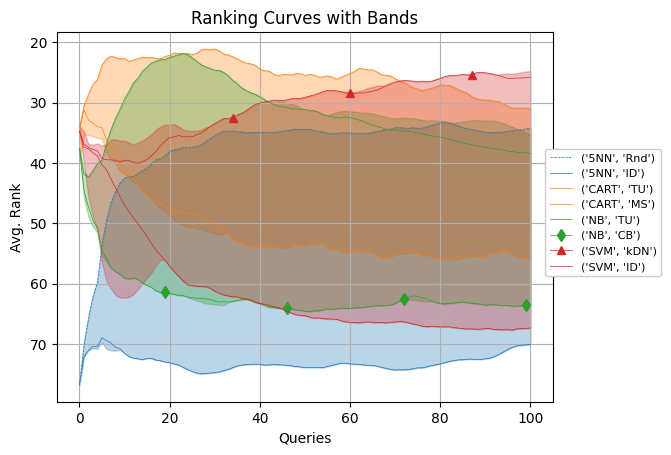

In [59]:
plot_ranking_curves_with_bands(avg_ranks_df)

### Analisando Bandas

In [40]:
def plot_learning_curves(avg_ranks_df, classifier):

    fig, ax = plt.subplots(figsize=(6,5))
    ax.grid(True)
    ax.invert_yaxis()
    ax.set_title(classifier)
    ax.set_xlabel("Queries")
    ax.set_ylabel("Avg. Ranks")
    

    # Calcula rank médio por query para cada 
    clf_ranks = avg_ranks_df.loc[classifier]
    auc_scores = {}
    for method, data in clf_ranks.groupby("method", sort=False):

        # aplica média móvel nos dados:
        smoothed_data = data.rolling(window=5, min_periods=1).mean()

        auc_scores[ABREV_DICT[method]] = np.trapz(smoothed_data)
        
        ax.plot(smoothed_data.values, utils.get_style(method),
                label=ABREV_DICT.get(method), color=COLOR_DICT[method], markevery=(0.3, 0.2),
                linewidth=(0.5 if utils.get_hm_type(method) != 'Classic' else 1.5) )
        
    handles, labels = plt.gca().get_legend_handles_labels()
    label_to_handle = {l: h for l, h in zip(labels, handles)}

    sorted_labels = sorted(auc_scores, key=auc_scores.get)
    plt.legend([label_to_handle[label] for label in sorted_labels],
               sorted_labels,
               loc='upper right', bbox_to_anchor=(1.2, 1.02), ncols=1, prop={'size': 8}, framealpha=1)

    plt.show()

In [41]:
w.interact(plot_learning_curves,
           avg_ranks_df=w.fixed(avg_ranks_df),
           classifier=w.ToggleButtons(options=utils.ABREV_MODEL.keys(), description="Leaner:"))

interactive(children=(ToggleButtons(description='Leaner:', options=('GaussianNB', 'SVC', 'DecisionTree', '5NN'…

<function __main__.plot_learning_curves(avg_ranks_df, classifier)>

### Compartamento de grupo de medidas por banda

In [42]:
def plot_group_bands(avg_ranks, ax, title=None):

    ax.set_title(title)
    ax.invert_yaxis()
    ax.grid(True)
    
    smoothed_ranks =  avg_ranks.groupby("method").transform( lambda x: x.rolling(window=5, min_periods=1).mean())
    
    df = smoothed_ranks.reset_index()
    df['group'] = df.method.apply(utils.get_hm_type)
    
    color_list = sns.color_palette(cc.glasbey_dark, n_colors=df['group'].nunique())
    i=0
    
    for group, data in df.groupby("group"):

        color = color_list[i]
        i+=1
        
        if group == 'Classic':
                
            continue
            

        min_ranks = data.groupby("query")["rank"].min()
        max_ranks = data.groupby("query")["rank"].max()
        
        ax.plot(max_ranks, color=color)
        ax.plot(min_ranks, color=color)
        ax.fill_between(np.arange(len(min_ranks)), min_ranks, max_ranks,
                        alpha=0.3,color=color, label=group,
                        hatch=utils.get_hm_hatch(group))

    for method, scores in df[df['group'] == 'Classic'].groupby("method", sort=False):
            ax.plot(scores["rank"].values, ':', linewidth=1,
                    label=ABREV_DICT[method], color=COLOR_DICT[method])
       

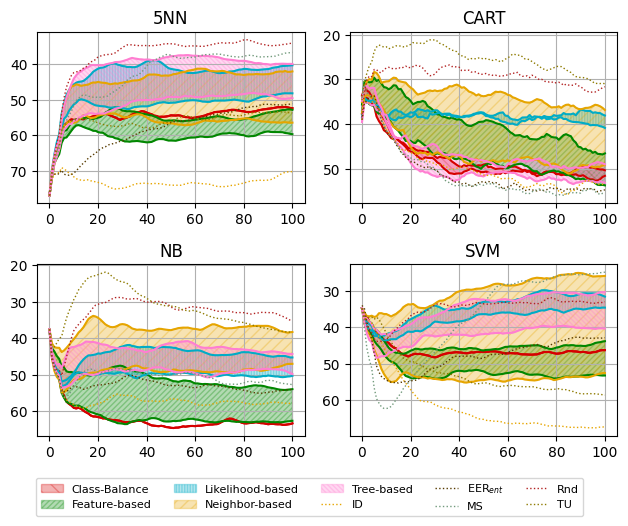

In [43]:
fig, axs = plt.subplots(2, 2)
for ax, clf in zip(axs.flatten(), sorted(utils.ABREV_MODEL.keys())):
    plot_group_bands(avg_ranks_df[clf], ax, title=utils.ABREV_MODEL[clf])
fig.tight_layout()
plt.legend(loc="lower center",bbox_to_anchor=(-0.15,-0.5),ncol=5, prop={'size': 8})

# Analisando desempenho por AULC

In [60]:
auc_scores = results_df.groupby(["classifier", "dataset", "method", "fold"]).kappa.apply(np.trapz).groupby(["classifier", "dataset", "method"]).mean()

In [62]:
auc_df = auc_scores.to_frame().reset_index().pivot(index=["classifier","dataset" ], columns="method", values="kappa")

In [66]:
from autorank import autorank

In [68]:
result = autorank(auc_df.unstack(level="classifier"))

In [174]:
auc_rank_df = result.rankdf[['meanrank']].reset_index()

auc_rank_df['method'] = auc_rank_df.method.transform(lambda x: utils.ABREV_DICT[x])
auc_rank_df['classifier'] = auc_rank_df.classifier.transform(lambda x: utils.ABREV_MODEL[x])

In [179]:
auc_rank_df.sort_values(by='meanrank').reset_index(drop=True)

,method,classifier,meanrank
0,TU,CART,21.255556
1,Rnd,CART,25.733333
2,kDN,SVM,27.727778
3,TU,NB,28.866667
4,LSR,CART,30.944444
...,...,...,...
87,F1I,NB,64.955556
88,ID,SVM,65.044444
89,CB,NB,65.411111
90,MV,NB,65.411111


In [149]:
result.cd

16.982927624960553

In [187]:

sorted_df = auc_rank_df.sort_values(by="meanrank").reset_index(drop=True)
sorted_df["Critical Region"] = sorted_df.meanrank.apply(lambda x: (x-result.cd, x+result.cd))

with pd.option_context('display.max_rows', None):
    display(sorted_df)
    

,method,classifier,meanrank,Critical Region
0,TU,CART,21.255556,"(4.272627930595004, 38.23848318051611)"
1,Rnd,CART,25.733333,"(8.750405708372782, 42.71626095829389)"
2,kDN,SVM,27.727778,"(10.744850152817225, 44.71070540273833)"
3,TU,NB,28.866667,"(11.883739041706114, 45.84959429162722)"
4,LSR,CART,30.944444,"(13.96151681948389, 47.927372069404996)"
5,LSR,SVM,31.027778,"(14.044850152817226, 48.01070540273833)"
6,Rnd,NB,31.522222,"(14.53929459726167, 48.50514984718278)"
7,TD$_U$,SVM,31.755556,"(14.772627930595004, 48.73848318051611)"
8,CLD,SVM,32.122222,"(15.139294597261667, 49.10514984718277)"
9,Rnd,SVM,33.522222,"(16.539294597261673, 50.50514984718278)"


In [190]:
def get_group(df, critical_region):
    l_bound, u_bound = critical_region
    mask = (df.meanrank >= l_bound) & (df.meanrank <=u_bound)
    return df[mask].index


for i in range(len(sorted_df)):
    print(get_group(sorted_df, sorted_df["Critical Region"].iloc[i]))

Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23],
      dtype='int64')
Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30],
      dtype='int64')
Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35],
      dtype='int64')
Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37],
      dtype='int64')
Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46],
      dtype='int64')
Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 

<Axes: >

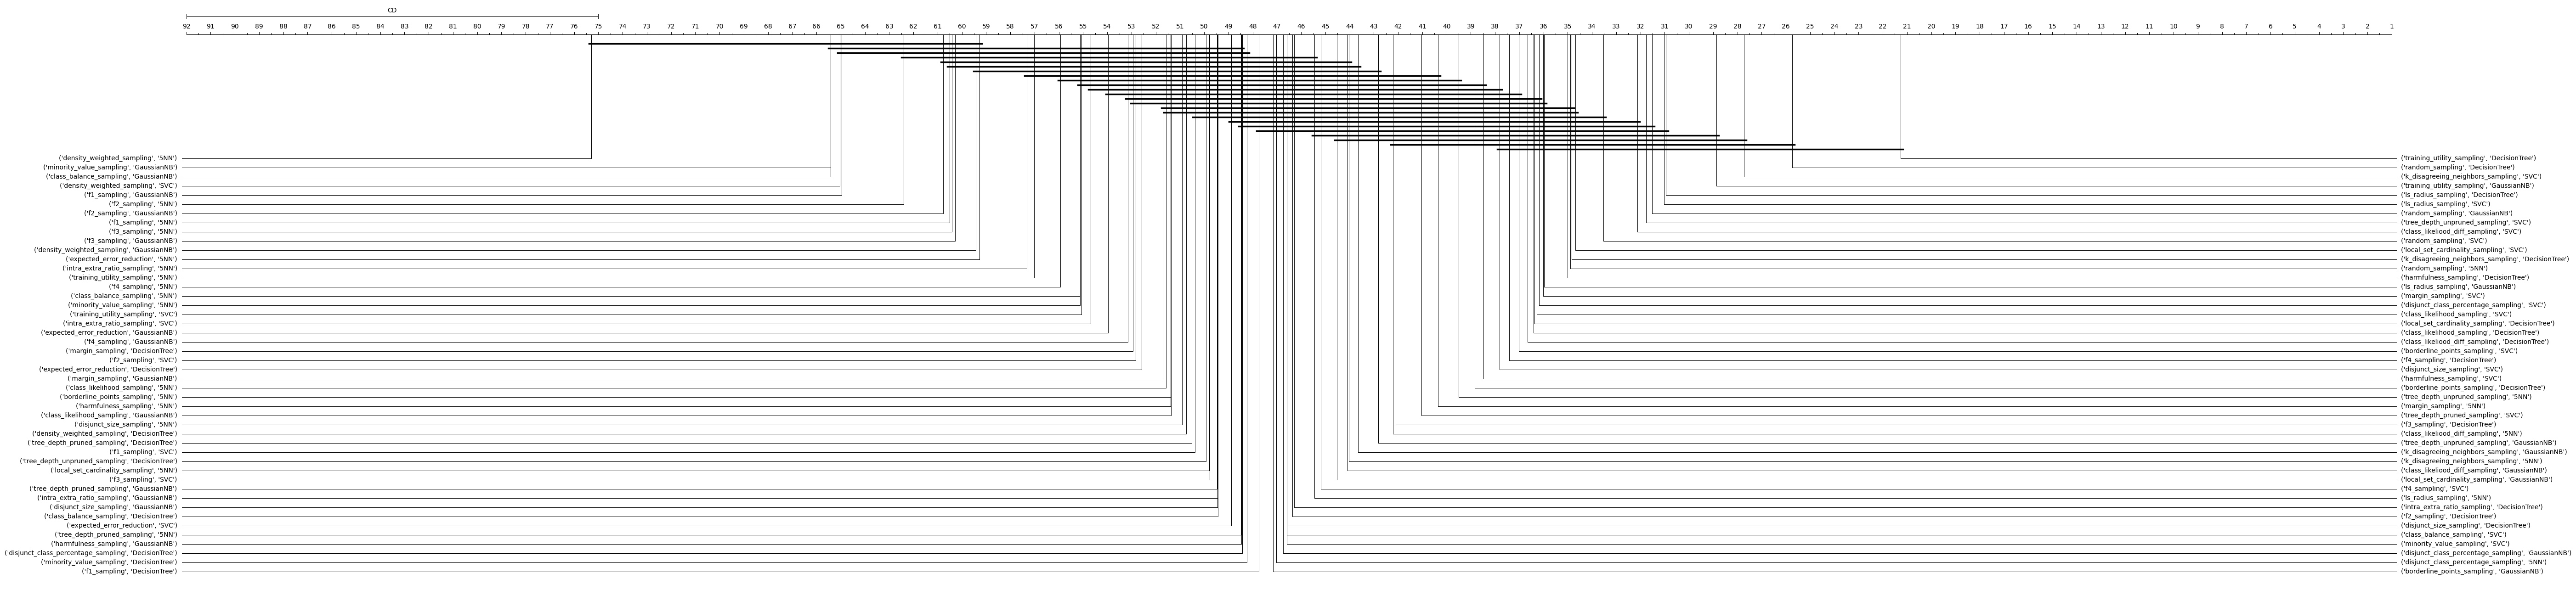

In [148]:
from autorank import plot_stats
plot_stats(result, width=50)

In [16]:
auc_scores = results_df.groupby(["classifier", "dataset", "method", "fold"]).kappa.apply(np.trapz).groupby(["classifier", "dataset", "method"]).mean()

In [136]:
auc_scores

classifier  dataset         method                       
5NN         abalone-3class  borderline_points_sampling       24.258985
                            class_balance_sampling           29.379646
                            class_likelihood_sampling        30.967617
                            class_likeliood_diff_sampling    32.091697
                            density_weighted_sampling        24.857044
                                                               ...    
SVC         yeast-4class    minority_value_sampling          31.044638
                            random_sampling                  33.631838
                            training_utility_sampling        21.345906
                            tree_depth_pruned_sampling       29.838349
                            tree_depth_unpruned_sampling     31.932086
Name: kappa, Length: 8280, dtype: float64

## Testes de Hipótese

In [21]:
from scipy.stats import friedmanchisquare, f

In [91]:
auc_df = auc_df.rename(columns=utils.ABREV_DICT)

In [92]:
for clf, data in auc_df.groupby("classifier"):
    samples = [data[column] for column in auc_df]
    print(clf, friedmanchisquare(*samples))

5NN FriedmanchisquareResult(statistic=314.7319424277723, pvalue=1.2430505994177677e-53)
DecisionTree FriedmanchisquareResult(statistic=463.34975845410645, pvalue=3.111570832005974e-84)
GaussianNB FriedmanchisquareResult(statistic=384.6242157196702, pvalue=6.0712477836436175e-68)
SVC FriedmanchisquareResult(statistic=310.84503753311344, pvalue=7.672096343146834e-53)


In [120]:
%matplotlib inline
from autorank import autorank, plot_stats


def plot_learner_stats(df, learner, alpha):
    result = autorank(df.loc[learner], alpha=alpha)
    plot_stats(result, width=15)
    plt.title(f"{learner} (alpha = {alpha})")

w.interact(plot_learner_stats,
          df=w.fixed(auc_df),
          learner=w.ToggleButtons(options=utils.ABREV_MODEL.keys(), value="SVC"),
          alpha=w.FloatSlider(min=0, max=1, step=0.01, value=0.05))
    

interactive(children=(ToggleButtons(description='learner', index=1, options=('GaussianNB', 'SVC', 'DecisionTre…

<function __main__.plot_learner_stats(df, learner, alpha)>

In [103]:
auc_df.index.get_level_values(0).unique()

Index(['5NN', 'DecisionTree', 'GaussianNB', 'SVC'], dtype='object', name='classifier')

In [ ]:
Orange.evaluation.gra

### Exemplo

In [ ]:
!pip install -q scikit_posthocs

In [ ]:
X = pd.DataFrame([[0.632,	0.760,	0.612,	0.740,	0.473],
                  [0.996,	0.997,	0.866,	0.948,	0.905],
                  [0.879,	0.912,	0.848,	0.834,	0.746],
                  [0.998,	0.996,	0.999,	0.980,	0.954],
                  [0.762,	0.752,	0.686,	0.724,	0.653],
                  [0.982,	0.974,	0.970,	0.951,	0.773],
                  [0.805,	0.855,	0.837,	0.821,	0.694],
                  [0.984,	0.989,	0.981,	0.977,	0.943],
                  [0.832,	0.805,	0.803,	0.855,	0.705],
                  [0.983,	0.983,	0.966,	0.932,	0.869],
                  [0.898,	0.914,	0.893,	0.930,	0.700],
                  [0.873,	0.914,	0.910,	0.892,	0.804]])

In [ ]:
test_result = friedmanchisquare(*[X[i] for i in range(5)])

In [ ]:
N, M = X.shape

In [ ]:
def get_f_stat(chi, N,M):
    ndf = M - 1
    ddf = (M-1)*(N-1)

    stat = ((N-1)*chi)/(N*(M-1) - chi)
    p_value = f.isf(0.05, ndf, ddf)
    
    return stat, p_value

f_stat = get_f_stat(test_result.statistic, N, M)
f_stat

In [ ]:
from scipy.stats import f


In [ ]:
get_f_stat(9.28, 14, 4) 